<a href="https://colab.research.google.com/github/TuncerCemUgurluer/Covid-19-and-pneumonia-detection-using-chest-X-ray-images/blob/main/Covid_19_and_Pneumonia_Detection_With_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tuncer Cem Uğurluer

2020

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [ ]:
!nvidia-smi

Fri Jan  6 21:22:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cemugurluer","key":"15e554976fa41a7274e8bcf1b35033b9"}'}

In [ ]:
!pip install opendatasets
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database"
od.download(dataset_url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 778M/778M [00:23<00:00, 35.4MB/s]


(299, 299)

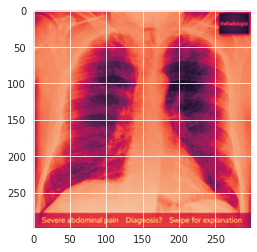

In [ ]:
covidimage=plt.imread("/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1005.png")
plt.imshow(covidimage)
covidimage.shape

(299, 299)

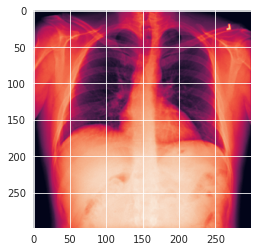

In [ ]:
normalimage=plt.imread("/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png")
plt.imshow(normalimage)
normalimage.shape

In [ ]:
import pandas as pd

In [ ]:
c = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
p = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [ ]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 3000) + os.listdir(p)

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [ ]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])


df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,/content/covid19-radiography-database/COVID-19...,2
1,/content/covid19-radiography-database/COVID-19...,2
2,/content/covid19-radiography-database/COVID-19...,2
3,/content/covid19-radiography-database/COVID-19...,2
4,/content/covid19-radiography-database/COVID-19...,2


In [ ]:
df["category"].unique()

array(['2', '0', '1'], dtype=object)

0 -> Normal
1 -> Viral Pneumonia
2 -> COVID

In [ ]:
df.shape

(7461, 2)

AttributeError: ignored

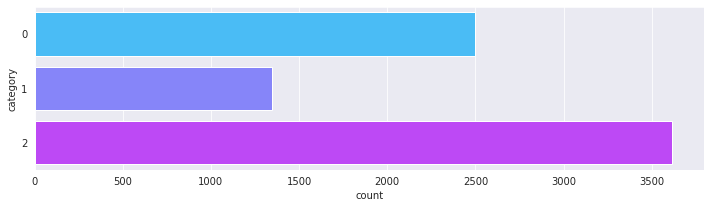

In [ ]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0],
              labels=['Normal', 'Viral Pneumonia', 'COVID'],
              label_type='center', size=15, color='w')
plt.show()

In [ ]:
import keras.utils as image

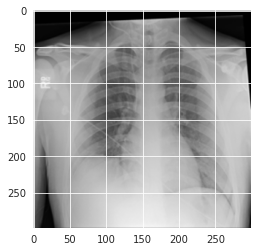

In [ ]:
sample = random.choice(df['filename'])
image = image.load_img(sample)
plt.imshow(image)
plt.show()

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


In [ ]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),

    )

x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(

        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),

        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
 history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=500,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )

Epoch 1/500
187/187 [==============================] - 144s 689ms/step - loss: 0.3508 - accuracy: 0.8666 - val_loss: 0.3340 - val_accuracy: 0.8795 - lr: 3.0000e-04
Epoch 2/500
187/187 [==============================] - 127s 678ms/step - loss: 0.1649 - accuracy: 0.9414 - val_loss: 0.1513 - val_accuracy: 0.9371 - lr: 3.0000e-04
Epoch 3/500
187/187 [==============================] - 127s 677ms/step - loss: 0.1135 - accuracy: 0.9596 - val_loss: 0.1234 - val_accuracy: 0.9438 - lr: 3.0000e-04
Epoch 4/500
187/187 [==============================] - 127s 678ms/step - loss: 0.0945 - accuracy: 0.9668 - val_loss: 0.1783 - val_accuracy: 0.9398 - lr: 3.0000e-04
Epoch 5/500
187/187 [==============================] - 128s 681ms/step - loss: 0.0809 - accuracy: 0.9703 - val_loss: 0.0888 - val_accuracy: 0.9652 - lr: 3.0000e-04
Epoch 6/500
187/187 [==============================] - 127s 678ms/step - loss: 0.0828 - accuracy: 0.9739 - val_loss: 0.1524 - val_accuracy: 0.9505 - lr: 3.0000e-04
Epoch 7/500
187/

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses=losses.drop("lr",axis=1)

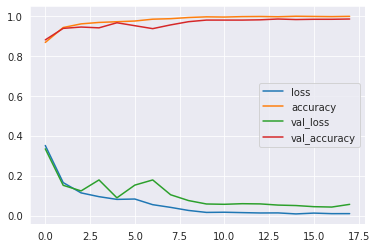

In [ ]:
losses.plot()

In [ ]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [ ]:
 model.evaluate(test_set)

24/24 [==============================] - 4s 167ms/step - loss: 0.0707 - accuracy: 0.9786


[0.07074041664600372, 0.9785522818565369]

In [ ]:
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1)


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID'], digits=5))

24/24 [==============================] - 4s 146ms/step


                 precision    recall  f1-score   support

         Normal    0.95720   0.98400   0.97041       250
Viral Pneumonia    1.00000   0.93284   0.96525       134
          COVID    0.98626   0.99171   0.98898       362

       accuracy                        0.97855       746
      macro avg    0.98115   0.96952   0.97488       746
   weighted avg    0.97899   0.97855   0.97850       746



In [ ]:
test_data["filename"][0]

'/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-759.png'

In [ ]:
test_data["category"][100]


'0'

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def predictImage(filename):
      img1 = image.load_img(filename,target_size=(224,224))
      plt.grid(False)

      plt.imshow(img1)

      Y = image.img_to_array(img1)
      Y=Y/255
      X = np.expand_dims(Y,axis=0)
      val = np.argmax(model.predict(X), axis=-1)
      val
      if (val==0):
        print("Normal")
      if(val==1):
        print(" Viral Pneumonia")
      if(val==2):
        print("Covid")

      return val



1/1 [==============================] - 0s 22ms/step
Covid


array([2])

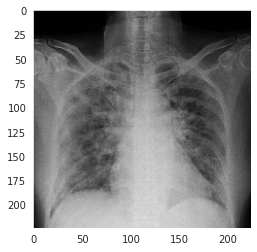

In [ ]:
predictImage("/content/x-ray-image-2b_full.jpg")

In [ ]:
model.save("/content/drive/MyDrive/advanced_homework/AI_HEALTHCARE_PROJECT.h5")